In [38]:
import sys
sys.path.insert(1, '../modules/')

import xarray as xr
import numpy as np
import gsw
import iris.quickplot as qplt
import matplotlib.pyplot as plt

import convenient_universal as uconv
import general_io as gio

In [2]:
bigthetao_file = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/bigthetao/gn/v20191108/bigthetao_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'
so_file = '/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/so/gn/v20191108/so_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'

## xarray

In [3]:
ds_bigthetao = xr.open_dataset(bigthetao_file)
ds_so = xr.open_dataset(so_file)

In [5]:
da_bigthetao = ds_bigthetao['bigthetao']
da_so = ds_so['so']

In [6]:
da_reference = da_bigthetao.isel({'time': 0}).drop('time')

In [9]:
target_shape = da_bigthetao.shape[1:]
print(target_shape)

(50, 300, 360)


In [10]:
da_depth = da_bigthetao['lev'] * -1

In [11]:
broadcast_latitude_xr = uconv.broadcast_array(da_bigthetao['latitude'].values, [1, 2], target_shape)

In [12]:
broadcast_depth_xr = uconv.broadcast_array(da_depth.values, 0, target_shape)

In [14]:
pressure_xr = gsw.p_from_z(broadcast_depth_xr, broadcast_latitude_xr)

In [15]:
da_pressure = xr.DataArray(pressure_xr, dims=da_reference.dims, coords=da_reference.coords)

In [16]:
alpha = xr.apply_ufunc(gsw.alpha, da_so, da_bigthetao, da_pressure,
                       dask='parallelized', output_dtypes=[da_so.dtype])

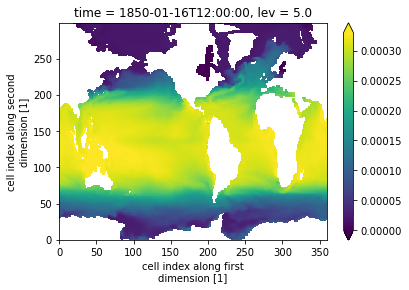

In [18]:
selection = alpha.isel({'time': 0, 'lev': 0}) #.where(alpha['alpha'].isel({'time': 0, 'lev': 0}) < 1.0)
selection.plot(vmin=0.0, vmax=0.00033)

## iris

In [19]:
bigthetao_cube, thetao_history = gio.combine_files(bigthetao_file, 'sea_water_conservative_temperature', checks=True)
so_cube, so_history = gio.combine_files(so_file, 'sea_water_salinity', checks=True)

/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'bigthetao'
  warnings.warn(
/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'bigthetao'
  warnings.warn(
/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'areacello', referenced by netCDF variable 'so'
  warnings.warn(
/g/data/xv83/dbi599/miniconda3/envs/cmip/lib/python3.9/site-packages/iris/fileformats/cf.py:861: UserWarning: Missing CF-netCDF measure variable 'volcello', referenced by netCDF variable 'so'
  warnings.warn(


In [20]:
depth = bigthetao_cube.coord('depth').points * -1

In [21]:
target_shape = bigthetao_cube.shape[1:]
print(target_shape)

(50, 300, 360)


In [22]:
broadcast_depth_iris = uconv.broadcast_array(depth, 0, target_shape)

In [23]:
broadcast_latitude_iris = uconv.broadcast_array(bigthetao_cube.coord('latitude').points, [1, 2], target_shape)

In [29]:
pressure_iris = gsw.p_from_z(broadcast_depth_iris, broadcast_latitude_iris)

In [45]:
coefficient_data = gsw.alpha(so_cube.data, bigthetao_cube.data, pressure_iris)

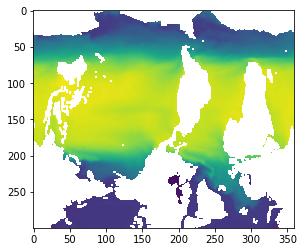

In [46]:
plt.imshow(coefficient_data[0, 0, ::])

In [44]:
bigthetao_cube[0, 0, ::].data.max()

31.893335

In [35]:
coefficient_data[0, 0, ::].mean()

0.0003302924562990187

In [36]:
alpha[0, 0, ::].mean()

<xarray.DataArray ()>
array(0.00019967)
Coordinates:
    time     datetime64[ns] 1850-01-16T12:00:00
    lev      float64 5.0

## Results

In [55]:
beta_file = '/g/data/e14/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/beta/gn/v20191108/beta_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'

In [56]:
ds_beta = xr.open_dataset(beta_file)

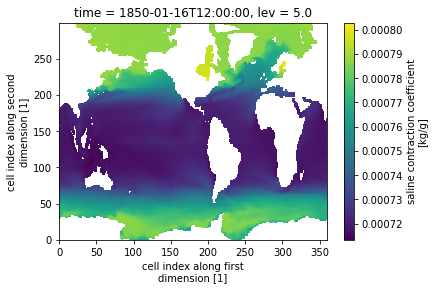

In [58]:
beta_da = ds_beta['beta'].isel({'time': 0, 'lev': 0}).where(ds_beta['beta'].isel({'time': 0, 'lev': 0}) < 1.0)
beta_da.plot()

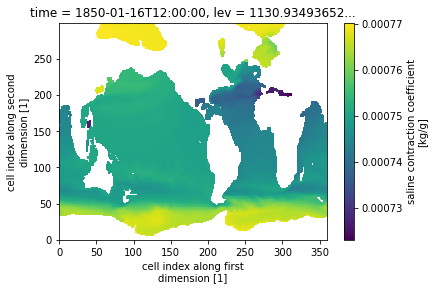

In [59]:
beta_da = ds_beta['beta'].isel({'time': 0, 'lev': 30}).where(ds_beta['beta'].isel({'time': 0, 'lev': 30}) < 1.0)
beta_da.plot()

In [47]:
alpha_file = '/g/data/e14/dbi599/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/historical/r1i1p1f1/Omon/alpha/gn/v20191108/alpha_Omon_ACCESS-CM2_historical_r1i1p1f1_gn_185001-185912.nc'

In [48]:
ds_alpha = xr.open_dataset(alpha_file)

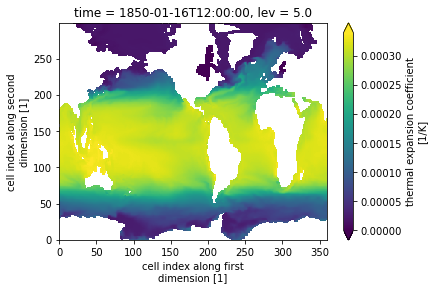

In [51]:
alpha_da = ds_alpha['alpha'].isel({'time': 0, 'lev': 0}).where(ds_alpha['alpha'].isel({'time': 0, 'lev': 0}) < 1.0)
alpha_da.plot(vmin=0.0, vmax=0.00034)

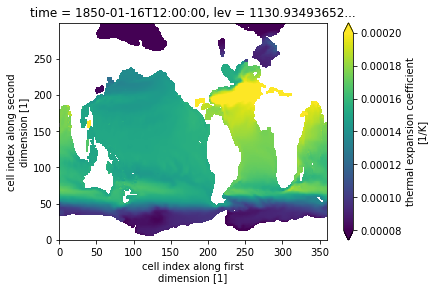

In [54]:
alpha_da = ds_alpha['alpha'].isel({'time': 0, 'lev': 30}).where(ds_alpha['alpha'].isel({'time': 0, 'lev': 30}) < 1.0)
alpha_da.plot(vmin=0.00008, vmax=0.0002)